In [1]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
from os import listdir, path, makedirs
from os.path import isfile, join
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import keras
from keras import datasets
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

# Carregamento do dataset

In [2]:
faces_path_treino = "imagens/treino/"
faces_path_teste = "imagens/teste/"
lista_faces_treino = [f for f in listdir(faces_path_treino) if isfile(join(faces_path_treino, f))]
lista_faces_teste = [f for f in listdir(faces_path_teste) if isfile(join(faces_path_teste, f))]

## Carregamento do dataset de treino

In [3]:
def carregar_imagem(caminho):
    imagem = imagem = cv2.imread(caminho)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem

In [4]:
dados_treinamento_tensor, sujeitos = [], []

In [5]:
for i, arq in enumerate(lista_faces_treino):
    imagem_path = faces_path_treino + arq
    imagem = carregar_imagem(imagem_path)
    imagem = frame = cv2.resize(imagem,(224,224))
    dados_treinamento_tensor.append(imagem)
    sujeito = arq[1:3]
    sujeitos.append(int(sujeito)-1)
dados_treinamento_tensor = np.asarray(dados_treinamento_tensor)/255
sujeitos = np.asarray(sujeitos)

### Teste do carregamento

0


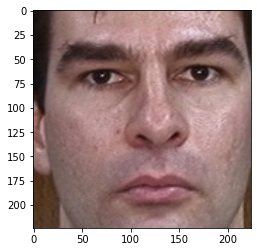

In [6]:
plt.imshow(dados_treinamento_tensor[0])
print(sujeitos[0])

## Carregamento do dataset de teste

In [7]:
dados_teste_tensor, sujeitos_teste = [], [] 

In [8]:
for i, arq in enumerate(lista_faces_teste):
    imagem_path = faces_path_teste + arq
    imagem = carregar_imagem(imagem_path)
    imagem = cv2.resize(imagem,(224,224))
    #imagem = imagem.reshape(1,224,224,3)
    imagem = np.array(imagem)
    dados_teste_tensor.append(imagem)
    sujeito = arq[1:3]
    sujeitos_teste.append(int(sujeito)-1)
dados_teste_tensor = np.asarray(dados_teste_tensor)/255
sujeitos_teste = np.asarray(sujeitos_teste)

(260,)


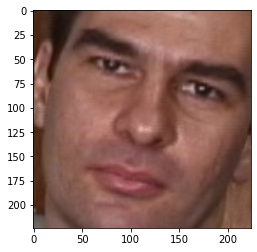

In [9]:
plt.imshow(dados_teste_tensor[0])
print(sujeitos_teste.shape)

# Desenvolvimento da rede

In [10]:
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [11]:
base_model = keras.applications.xception.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [12]:
base_model.trainable = False

In [13]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a bouble softmax unit (binary classification)
outputs = keras.layers.Dense(52,activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

In [14]:
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, 
              loss=[losses.sparse_categorical_crossentropy], metrics=['accuracy'])
history = model.fit(dados_treinamento_tensor, sujeitos, validation_data=(dados_teste_tensor, sujeitos_teste), batch_size=5, epochs=40)

Epoch 1/40
104/104 [==============================] - 89s 840ms/step - loss: 3.7312 - accuracy: 0.1385 - val_loss: 3.0052 - val_accuracy: 0.4115
Epoch 2/40
104/104 [==============================] - 104s 1s/step - loss: 2.3458 - accuracy: 0.5981 - val_loss: 2.4655 - val_accuracy: 0.4500
Epoch 3/40
104/104 [==============================] - 109s 1s/step - loss: 1.6547 - accuracy: 0.8231 - val_loss: 2.0885 - val_accuracy: 0.6077
Epoch 4/40
104/104 [==============================] - 97s 936ms/step - loss: 1.2309 - accuracy: 0.8865 - val_loss: 1.9017 - val_accuracy: 0.5885
Epoch 5/40
104/104 [==============================] - 97s 933ms/step - loss: 0.9393 - accuracy: 0.9269 - val_loss: 1.7609 - val_accuracy: 0.6231
Epoch 6/40
104/104 [==============================] - 99s 958ms/step - loss: 0.7445 - accuracy: 0.9538 - val_loss: 1.6264 - val_accuracy: 0.6500
Epoch 7/40
104/104 [==============================] - 109s 1s/step - loss: 0.5966 - accuracy: 0.9692 - val_loss: 1.5669 - val_accuracy

## Exportar dados

In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

C:\Users\neiju\anaconda3\envs\vc-analise-facial\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [16]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [26]:
loaded_model.compile(optimizer="Adam", 
              loss=[losses.sparse_categorical_crossentropy], metrics=['accuracy'])

In [27]:
_,acuracia = loaded_model.evaluate(dados_teste_tensor, sujeitos_teste)


9/9 [==============================] - 29s 3s/step - loss: 1.1713 - accuracy: 0.6923


In [28]:
print("A acuracia da rede foi: %.2f" %(acuracia*100) + "%")

A acuracia da rede foi: 69.23%
